In [35]:
import pandas as pd
import talib as ta
import matplotlib.pyplot as plt
import numpy as np

import plotly 
import plotly.io as pio
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

In [4]:
colnames = ['Data','Open','High','Low','Close','Vol']
df = pd.read_csv('./Forex Data/EURUSD_eatradingacademy/EURUSD1.csv', sep = '\t', header=None, names = colnames)

In [5]:
df = df.iloc[:1000]

In [42]:
df['MA_50'] = ta.SMA(df['Close'],timeperiod=50)
df['MA_200'] = ta.SMA(df['Close'],timeperiod=200)
df['EMA'] = ta.EMA(df['Close'], timeperiod = 5)
df['RSI'] = ta.RSI(df['Close'],14)
df['BB_up'],df['BB_mid'],df['BB_low'] = ta.BBANDS(df['Close'], timeperiod=20, nbdevup=2, nbdevdn=2, matype=0)
df['MFI'] = ta.MFI(df['High'], df['Low'], df['Close'], df['Vol'], timeperiod=14)
df['TEMA_S'] = ta.TEMA(df['Close'], timeperiod = 12)
df['TEMA_L'] = ta.TEMA(df['Close'], timeperiod = 36)
df['Tamanho_candle'] = abs(df['Close'] - df['Open'])
df['Tamanho_total'] = abs(df['High'] - df['Low'])
df['slowk'], df['slowd'] = ta.STOCH(df['High'], df['Low'], df['Close'], fastk_period=5, slowk_period=3, slowk_matype=0, slowd_period=3, slowd_matype=0)
#df['Tendencia'] = df['MA_200'].apply(lambda x: 'Alta' if df['Close'] > x else 0)


df['BB_p'] = (df['Close'] - df['BB_low'])/(df['BB_up'] - df['BB_low'])

In [7]:
index = df.index
max_holding = 100

holdings = pd.DataFrame(index=df.index, data={'Holdings': np.array([np.nan] * index.shape[0])})
holdings.loc[((df['RSI'] < 20)& (df['BB_p'] < 0)), 'Holdings'] = max_holding
holdings.loc[((df['RSI'] > 80)& (df['BB_p'] > 1)), 'Holdings'] = 0
holdings.ffill(inplace=True)
holdings.fillna(0, inplace=True)

holdings['Order'] = holdings.diff()
holdings.dropna(inplace=True)

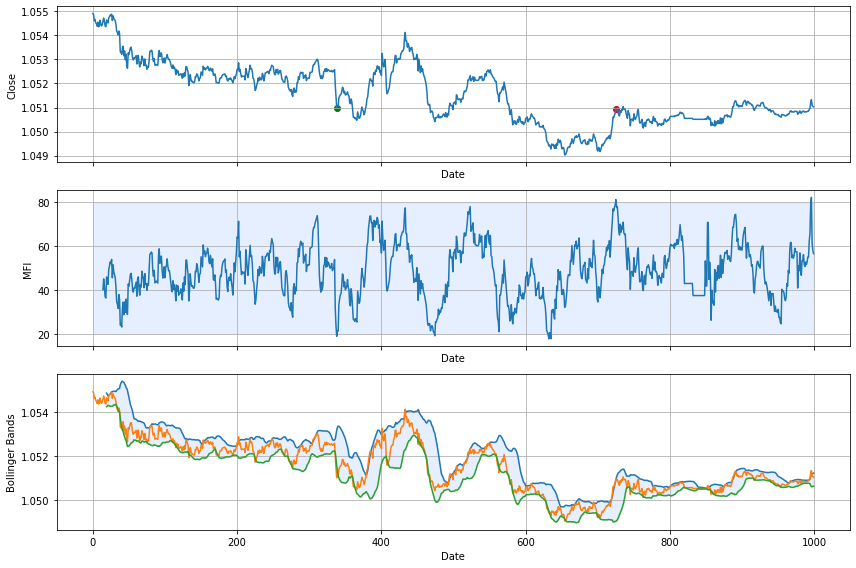

In [68]:
fig, (ax0, ax1, ax2) = plt.subplots(3, 1, sharex=True, figsize=(12, 8))
ax0.plot(index, df['Close'], label='Close')
ax0.set_xlabel('Date')
ax0.set_ylabel('Close')
ax0.grid()
for day, holding in holdings.iterrows():
    order = holding['Order']
    if order > 0:
        ax0.scatter(x=day, y=df.loc[day, 'Close'], color='green')
    elif order < 0:
        ax0.scatter(x=day, y=df.loc[day, 'Close'], color='red')

ax1.plot(index, df['RSI'], label='MFI')
ax1.fill_between(index, y1=20, y2=80, color='#adccff', alpha=0.3)
ax1.set_xlabel('Date')
ax1.set_ylabel('MFI')
ax1.grid()

ax2.plot(index, df['BB_up'], label='BB_up')
ax2.plot(index, df['Close'], label='Close')
ax2.plot(index, df['BB_low'], label='BB_low')
ax2.fill_between(index, y1=df['BB_low'], y2=df['BB_up'], color='#adccff', alpha=0.3)
ax2.set_xlabel('Date')
ax2.set_ylabel('Bollinger Bands')
ax2.grid()

fig.tight_layout()
plt.show()

In [15]:
#Candlesticks

fig = go.Figure(data=[go.Candlestick(x=df['Data'],
                open=df['Open'],
                high=df['High'],
                low=df['Low'],
                close=df['Close'],
                increasing_line_color= 'green', decreasing_line_color= 'red')])

fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=15, label="15m", step="minute", stepmode="backward"),
            dict(count=45, label="45m", step="minute", stepmode="backward"),
            dict(count=1, label="HTD", step="hour", stepmode="todate"),
            dict(count=3, label="3h", step="hour", stepmode="backward"),
            dict(step="all")
        ])
    )
)


fig.show()

In [59]:
list_green_x = []
list_green_y = []

fig = go.Figure()
fig.add_trace(go.Scatter(x=df.index, y=df.MA_200, name='EMA 200'))
fig.add_trace(go.Scatter(x=df.index, y=df.Close, name='Close', opacity=1))
for day, holding in holdings.iterrows():
    order = holding['Order']
    if order > 0:
        list_green_x.append(day)
        list_green_y.append(df.loc[day, 'Close'])
        #fig.add_trace(go.Scatter(x=day, y=df.loc[day, 'Close'], name='Close', opacity=1))
    elif order < 0:
        #fig.add_trace(go.Scatter(x=day, y=df.loc[day, 'Close'], name='Close', opacity=1))
        pass
fig.add_trace(go.Scatter(x=list_green_x, y=list_green_y, name='Point'))
fig.show()

In [46]:
fig = go.Figure()

# add subplot properties when initializing fig variable ***don't forget to import plotly!!!***
fig = plotly.subplots.make_subplots(rows=3, cols=1, shared_xaxes=True, vertical_spacing=0.01, row_heights=[0.5,0.1,0.2])

# Plot price data on the 1st subplot (using code from last article)
fig.add_trace(go.Candlestick(x=df.Data, open=df['Open'],high=df['High'],low=df['Low'],close=df['Close'], name='market data'))
fig.add_trace(go.Scatter(x=df.Data,y=df['MA_50'],opacity=0.7,line=dict(color='blue', width=2),name='MA 50'))
fig.add_trace(go.Scatter(x=df.Data,y=df['MA_200'],opacity=0.7,line=dict(color='orange', width=2),name='MA 20'))

# Plot volume trace on 2nd row in our figure
fig.add_trace(go.Scatter(x=df.Data, y=df['MFI']), row=2, col=1)

# Plot MACD trace on 3rd row
fig.add_trace(go.Scatter(x=df.Data, y=df['RSI']), row=3, col=1)


# Update the layout by changing the figure size, hiding the legend and rangeslider
fig.update_layout(height=500, width=600, showlegend=False, xaxis_rangeslider_visible=False)


fig.show()